# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from sklearn.utils import class_weight
from keras.models import load_model
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report

# Import libraries

In [2]:
batch_size = 10
img_height = 128
img_width = 128
num_class = 3
train_dir= './Data/3_class_init/train/'
val_dir= './Data/3_class_init/validation/'
test_dir= './Data/3_class_init/test/'
model_dir = './Models/model_mobile_3_class/'

In [3]:
# Data for Training
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
)

Found 2604 files belonging to 3 classes.


2022-06-21 00:08:55.000264: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 00:08:55.044339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 00:08:55.044756: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 00:08:55.046594: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
# Data for validation
val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        labels='inferred',
        label_mode='categorical',
        batch_size=batch_size,
        image_size=(img_height, img_width),
        shuffle=True,
)

Found 651 files belonging to 3 classes.


In [5]:
# Data for Testing
test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        labels='inferred',
        label_mode='categorical',
        batch_size=batch_size,
        image_size=(img_height, img_width),
        shuffle=True,
)

Found 814 files belonging to 3 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['bad_mask', 'with_mask', 'without_mask']


In [7]:
# Get weights to balance classes

lab =[]
for images, labels in train_ds.take(-1):  
    lab.extend(labels.numpy())

tru=[]
for i in lab:
    tru.append(np.argmax(i))
    

tru
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(tru),
                                                  y=tru)
name = [0,1,2]
weight = dict(zip(name,class_weights))
print(weight)

{0: 11.421052631578947, 1: 0.42013552758954503, 2: 1.878787878787879}


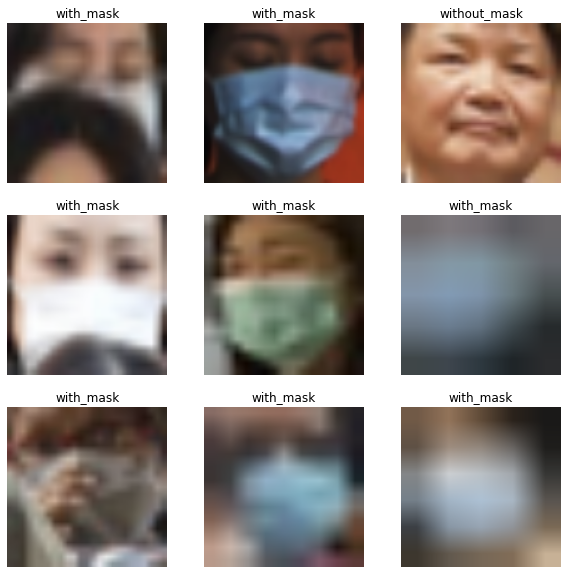

In [8]:
# Show some images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

# Data augmentation

In [9]:
# Add some augmentation layers to change the imputs pictures slightly
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomBrightness(0.1, value_range=(1,250)),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

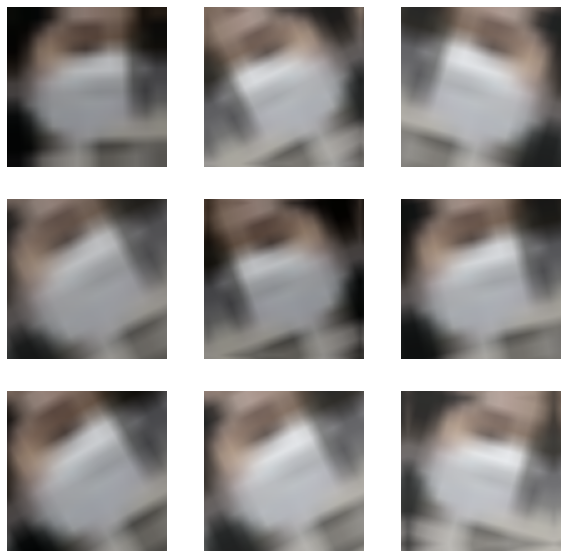

In [10]:
# Show some augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype(np.uint8))
        plt.axis("off")

# Create Model

In [11]:
# Create base model with MobileNetV2 architecture
base_model = keras.applications.MobileNetV2(
    weights='imagenet',  # load pretrained ImageNet weights
    input_shape=(img_width, img_height, 3),
    include_top=False)  # Delete last layer of the model 

# Freeze pretrained weights
base_model.trainable = False

# Create the imput of our model
inputs= keras.Input(shape=(img_height, img_width, 3))

#  Augmentation
x = data_augmentation(inputs)

# Add a preprocessing layer specific to this architecture
x = keras.applications.mobilenet_v2.preprocess_input(x)

# Add both models
x = base_model(x, training=False)

# Convert our features vector into a 1-D vector
x = keras.layers.GlobalAveragePooling2D()(x)

# Add a Dropout layer to stop overfitting
x = keras.layers.Dropout(0.5)(x)

# Add a final layer with our classes
outputs = keras.layers.Dense(num_class, activation='softmax')(x)

# Final model
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                             

In [12]:
opt = keras.optimizers.SGD(learning_rate=0.01)

# Compile the model
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics= ['accuracy']
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                             

# First round of training

In [13]:
# Add some callbacks to stop the fit process if needed
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath= model_dir + 'checkpoint/',
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True,
        save_weights_only=True,
        mode="auto",
        save_freq="epoch",
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        verbose=1,
        mode="auto",
        restore_best_weights=True,
    ),
]

# Train the model
history = model.fit(
    train_ds,
    class_weight=weight,
    validation_data=val_ds,
    epochs=50,
    batch_size = batch_size,
    callbacks=my_callbacks
)


Epoch 1/50


2022-06-21 00:09:17.265041: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


261/261 [==============================] - 31s 91ms/step - loss: 3.2216 - accuracy: 0.5380 - val_loss: 5.6966 - val_accuracy: 0.2642
Epoch 2/50
261/261 [==============================] - 21s 81ms/step - loss: 2.7948 - accuracy: 0.6121 - val_loss: 0.9913 - val_accuracy: 0.7680
Epoch 3/50
261/261 [==============================] - 22s 82ms/step - loss: 3.1821 - accuracy: 0.6187 - val_loss: 2.0551 - val_accuracy: 0.6406
Epoch 4/50
261/261 [==============================] - 21s 81ms/step - loss: 2.6053 - accuracy: 0.6763 - val_loss: 1.1341 - val_accuracy: 0.7634
Epoch 5/50
261/261 [==============================] - 20s 78ms/step - loss: 2.6895 - accuracy: 0.6697 - val_loss: 7.0279 - val_accuracy: 0.3118
Epoch 6/50
261/261 [==============================] - 21s 80ms/step - loss: 2.8899 - accuracy: 0.6855 - val_loss: 4.6172 - val_accuracy: 0.4393
Epoch 7/50
261/261 [==============================] - 21s 80ms/step - loss: 2.8758 - accuracy: 0.6912 - val_loss: 5.4096 - val_accuracy: 0.4531
Epo

In [14]:
# Save the model
model.save(model_dir+'Model/')

INFO:tensorflow:Assets written to: ./Models/model_mobile_3_class/Model/assets


INFO:tensorflow:Assets written to: ./Models/model_mobile_3_class/Model/assets


# Results

In [15]:
# Verify our model with the test data
lab =[]
preds = []
for images, labels in test_ds.take(-1):  
    lab.extend(labels.numpy())
    preds.extend(model.predict(images,verbose=0))

tru=[]
for i in lab:
    tru.append(np.argmax(i))
    
pre = []
for i in preds:
    pre.append(np.argmax(i))
    
print('Confusion:','\n',confusion_matrix(tru,pre),'\n')
print(classification_report(tru, pre,target_names=class_names,digits=num_class))

Confusion: 
 [[ 13   9   0]
 [107 519  21]
 [ 36  21  88]] 

              precision    recall  f1-score   support

    bad_mask      0.083     0.591     0.146        22
   with_mask      0.945     0.802     0.868       647
without_mask      0.807     0.607     0.693       145

    accuracy                          0.762       814
   macro avg      0.612     0.667     0.569       814
weighted avg      0.897     0.762     0.817       814



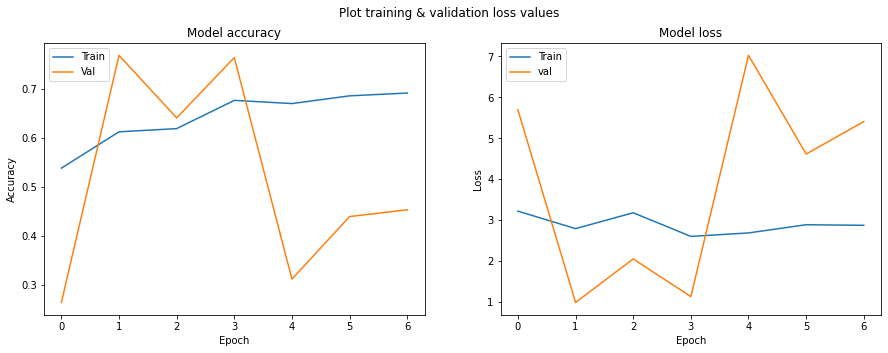

In [16]:
# Fit graphs
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (15,5))

fig.suptitle('Plot training & validation loss values')
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'val'], loc='upper left')

plt.show()

# Second round of training

In [17]:
# Train the model a second time with the whole model unfreezed
base_model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                             

In [18]:
# Compile the model again
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=1e-6),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add some callbacks to stop the fit process if needed
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=model_dir +'checkpoint/',
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True,
        save_weights_only=True,
        mode="auto",
        save_freq="epoch",
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=2,
        verbose=1,
        mode="auto",
        restore_best_weights=True,
    ),
]

# Train the model again
history = model.fit(
    train_ds, 
    class_weight=weight,
    validation_data=val_ds,
    epochs=10,
    batch_size = batch_size,
    callbacks=my_callbacks
)

Epoch 1/10


261/261 [==============================] - 62s 201ms/step - loss: 1.5396 - accuracy: 0.6759 - val_loss: 0.7033 - val_accuracy: 0.7143
Epoch 2/10
261/261 [==============================] - 50s 191ms/step - loss: 0.9207 - accuracy: 0.7093 - val_loss: 0.8965 - val_accuracy: 0.6144
Epoch 3/10
261/261 [==============================] - 50s 193ms/step - loss: 1.0008 - accuracy: 0.6705 - val_loss: 0.6733 - val_accuracy: 0.7250
Epoch 4/10
261/261 [==============================] - 50s 191ms/step - loss: 0.8483 - accuracy: 0.6893 - val_loss: 0.5718 - val_accuracy: 0.7527
Epoch 5/10
261/261 [==============================] - 54s 208ms/step - loss: 0.8043 - accuracy: 0.6847 - val_loss: 0.5913 - val_accuracy: 0.7512
Epoch 6/10
261/261 [==============================] - 52s 199ms/step - loss: 0.8199 - accuracy: 0.7131 - val_loss: 0.5603 - val_accuracy: 0.7665
Epoch 7/10
261/261 [==============================] - 52s 199ms/step - loss: 0.7117 - accuracy: 0.7331 - val_loss: 0.5384 - val_accuracy: 0.7

In [19]:
# Save the model
model.save(model_dir+'Model/')

INFO:tensorflow:Assets written to: ./Models/model_mobile_3_class/Model/assets


INFO:tensorflow:Assets written to: ./Models/model_mobile_3_class/Model/assets


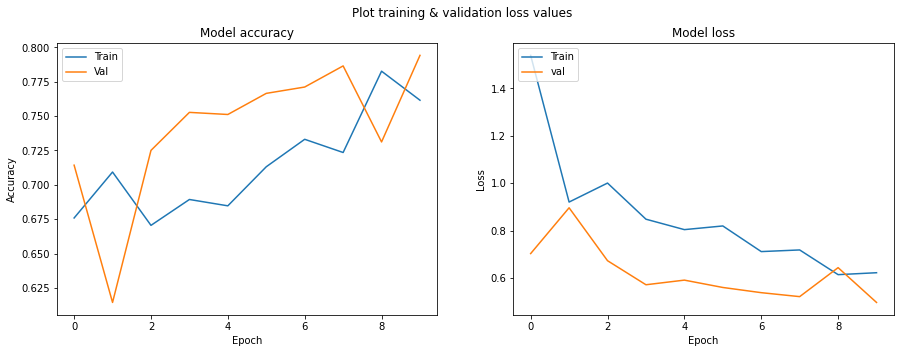

In [20]:
# Fit graphs
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (15,5))

fig.suptitle('Plot training & validation loss values')
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'val'], loc='upper left')

plt.show()

In [21]:
# Verify our model with the test data again 
lab =[]
preds = []
for images, labels in test_ds.take(-1):  
    lab.extend(labels.numpy())
    preds.extend(model.predict(images,verbose=0))

tru=[]
for i in lab:
    tru.append(np.argmax(i))
    
pre = []
for i in preds:
    pre.append(np.argmax(i))

print('Confusion:','\n',confusion_matrix(tru,pre),'\n')
print(classification_report(tru, pre,target_names=class_names, digits=num_class))

Confusion: 
 [[ 14   6   2]
 [ 62 522  63]
 [  9   7 129]] 

              precision    recall  f1-score   support

    bad_mask      0.165     0.636     0.262        22
   with_mask      0.976     0.807     0.883       647
without_mask      0.665     0.890     0.761       145

    accuracy                          0.817       814
   macro avg      0.602     0.778     0.635       814
weighted avg      0.898     0.817     0.845       814

